# ASX rate tracker

Note: Data prior to 12 April sourced from Matt Cowgill's github repo:
https://github.com/MattCowgill/cash-rate-scraper.git

## Python set-up

In [1]:
import glob
from pathlib import Path
from functools import cache
import dateutil.parser as dparser

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import readabs as ra

In [2]:
import plotting as pg


In [3]:
# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/ASX/"
pg.set_chart_dir(CHART_DIR)
pg.clear_chart_dir(CHART_DIR)

RFOOTER = "ASX Rate Tracker"
LFOOTER = "Australia. "
FOOTERS = {"lfooter": LFOOTER, "rfooter": RFOOTER}

# True to see the charts in the notebook
SHOW = True

In [4]:
# Save the combined data to a file (for posterity?)
SAVE_DIR = "./ASX-COMBINED/"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
SAVE_FILE = SAVE_DIR + "ASX-COMBINED.csv"

## ASX data cleaning and aggregation

In [5]:
def aggregate_data() -> pd.DataFrame:
    """Aggregate daily cash rate data into a single dataframe.
    Delete daily data that looks odd."""

    # Find files
    directory = "./ASX_DAILY_DATA/"
    file_stem = "scraped_cash_rate_"
    pattern = f"{directory}{file_stem}*.csv"
    files = glob.glob(pattern)

    # Read each file into a dataframe and then put it in a dictionary
    dict_of_series = {}
    for file in files:
        file_date = file.rsplit(r"_", 1)[1].split(r".")[0]
        day_data = pd.read_csv(file, index_col=0)
        cash_rate_day = day_data["cash_rate"].dropna().round(3)
        cash_rate_day.index = pd.PeriodIndex(cash_rate_day.index, freq="M")
        dict_of_series[file_date] = cash_rate_day

    # Create a new dataframe, order rhw rows and columns
    combined_df = (
        pd.DataFrame(dict_of_series)
        .T.sort_index(ascending=True)
        .sort_index(ascending=True, axis=1)
    )
    combined_df.index = pd.PeriodIndex(combined_df.index, freq="D")

    # This list comes from Matt Cowgill's code
    matts_drop_list = [
        "2022-08-06",
        "2022-08-07",
        "2022-08-08",
        "2023-01-18",
        "2023-01-24",
        "2023-01-31",
        "2023-02-02",
        "2022-12-30",
        "2022-12-29",
    ]
    combined_df = combined_df.drop(matts_drop_list, errors="ignore")

    # drop saturday/sunday data
    combined_df = combined_df[~combined_df.index.dayofweek.isin([5, 6])]

    # save to file
    combined_df.to_csv(SAVE_FILE)

    return combined_df


df = aggregate_data()
print(f"Data fron: {df.index.min()}; to: {df.index.max()}.")

Data fron: 2022-04-21; to: 2024-07-17.


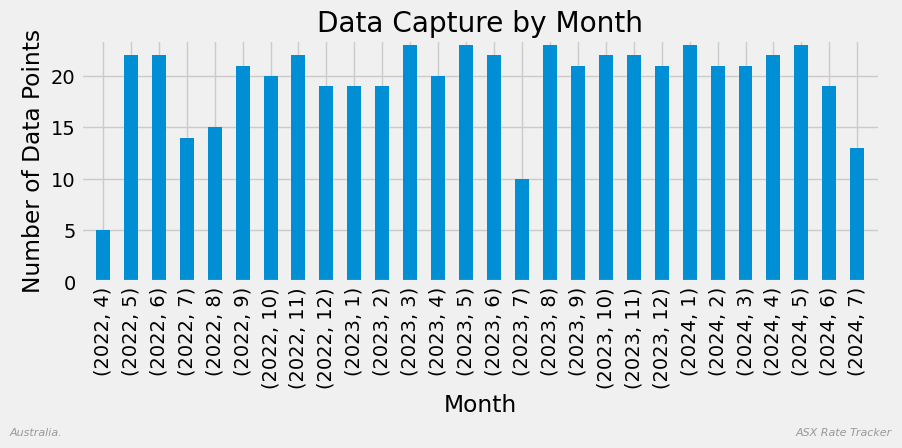

In [6]:
def data_capture_by_month():
    """Bar chart - number of data points captured by year-month.
    This is a good way to see where there are gaps in the data."""

    ax = (
        df.groupby([df.index.year, df.index.month])
        .agg({"count"})
        .max(axis=1)
        .plot.bar()
    )
    pg.finalise_plot(
        ax,
        title="Data Capture by Month",
        xlabel="Month",
        ylabel="Number of Data Points",
        **FOOTERS,
        show=SHOW,
    )


data_capture_by_month()

## Anticipated RBA Official Cash Rates

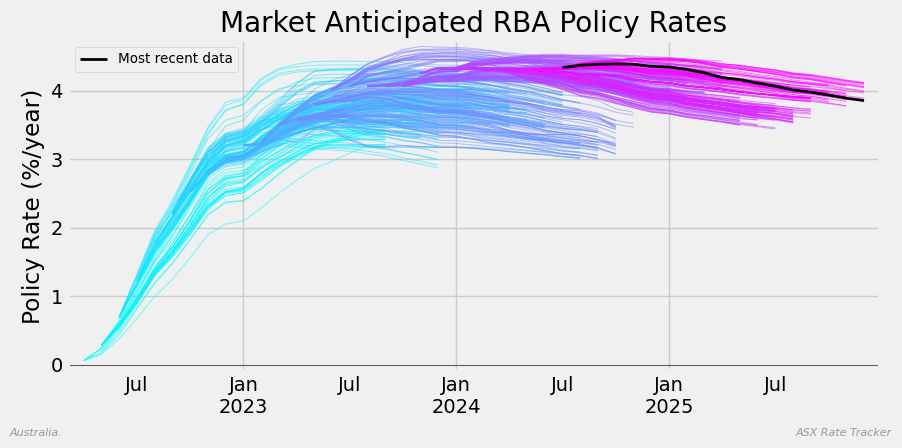

In [7]:
def plot_anticipated():
    """Plot daily ASX rate tracker implied market forecasts."""

    data = df.T.copy()
    columns = [f"_{x}" for x in data.columns]
    data.columns = columns
    num_columns = len(data.columns)
    colors = sns.color_palette("cool", num_columns)
    ax = data.plot(color=colors, lw=0.75, alpha=0.5)
    columns[-1] = columns[-1].replace("_", "")
    data.columns = columns
    ax = data[data.columns[-1]].plot(color="black", lw=2, label="Most recent data")

    pg.finalise_plot(
        ax,
        title="Market Anticipated RBA Policy Rates",
        ylabel="Policy Rate (%/year)",
        y0=True,
        zero_y=True,
        **FOOTERS,
        legend={"loc": "best", "fontsize": "x-small"},
        show=SHOW,
    )


plot_anticipated()

## Monthly against RBA rate


cache_only=False verbose=False


/Users/bryanpalmer/ABS/notebooks/plotting.py:344: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(pad=1.1)


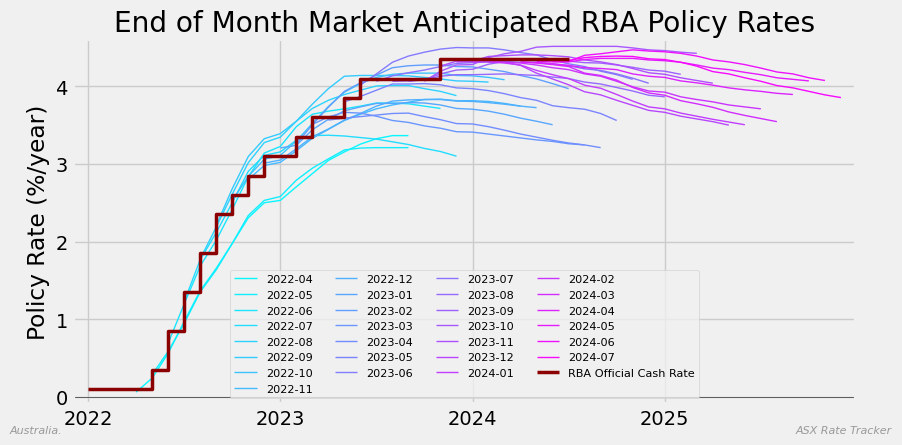

In [8]:
def plot_against_rba():
    """Plot end of month ASX rate tracker forecasts against RBA cash rate.
    Limit to end of month to declutter the plot."""

    # Get end-of-month ASX forecast data
    asx_data = df.copy()
    asx_data.index = pd.PeriodIndex(asx_data.index, freq="M")
    drops = asx_data.index.duplicated(keep="last")
    asx_data = asx_data[~drops].T

    # plot the ASX data with a different colour for each column
    num_columns = len(asx_data.columns)
    colors = sns.color_palette("cool", num_columns)
    ax = asx_data.plot(color=colors, lw=1)

    # Get and plot the RBA data
    ocr = ra.read_rba_ocr()["2022-01":]
    ax = ocr.plot(
        ax=ax,
        color="darkred",
        lw=2.5,
        label="RBA Official Cash Rate",
        drawstyle="steps-post",
    )

    # finalise the plot
    pg.finalise_plot(
        ax,
        title="End of Month Market Anticipated RBA Policy Rates",
        ylabel="Policy Rate (%/year)",
        y0=True,
        zero_y=True,
        **FOOTERS,
        legend={"loc": "lower center", "fontsize": "xx-small", "ncols": 4},
        show=SHOW,
    )


plot_against_rba()

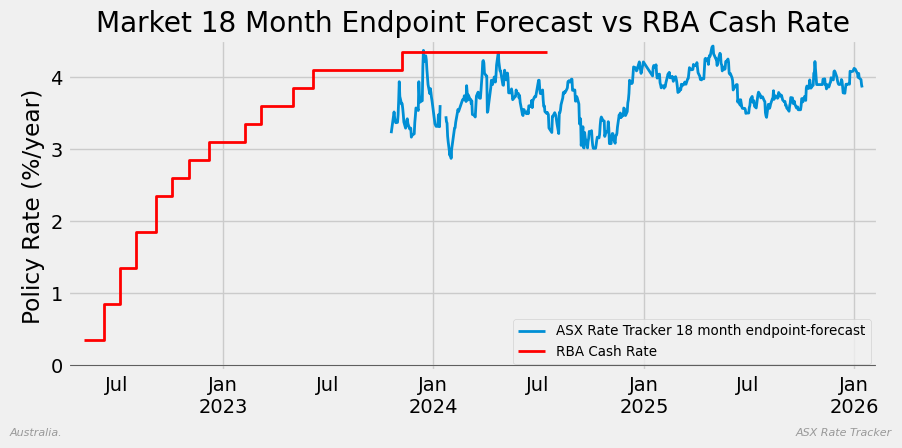

In [9]:
def endpoint_comparison():
    """Compare the endpoint forecast against the actual RBA rate."""

    # Endpoint rate against the actual RBA rate
    endpoint = df.copy().T.ffill().iloc[-1]
    endpoint.index += int(365 * 3 / 2)  # 18 months in days
    rba = ra.read_rba_ocr(monthly=False)["2022-01-01":].astype(float)
    ax = endpoint.plot(label="ASX Rate Tracker 18 month endpoint-forecast", lw=2)
    rba.plot(ax=ax, label="RBA Cash Rate", lw=2, color="red", drawstyle="steps-post")
    pg.finalise_plot(
        ax,
        title="Market 18 Month Endpoint Forecast vs RBA Cash Rate",
        ylabel="Policy Rate (%/year)",
        y0=True,
        zero_y=True,
        **FOOTERS,
        legend={"loc": "best", "fontsize": "x-small"},
        show=SHOW,
    )


endpoint_comparison()

## Finished

In [10]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Jul 17 2024 22:03:09

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

matplotlib: 3.9.1
seaborn   : 0.13.2
readabs   : 0.0.12a2
numpy     : 1.26.4
pandas    : 2.2.2
dateutil  : 2.9.0

Watermark: 2.4.3

